In [15]:
import os
import math
import pickle
from collections import defaultdict

import wandb
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt

In [16]:
metric_names = ["world_knowledge", "commonsense_reasoning", "language_understanding", "symbolic_problem_solving", "reading_comprehension"]
metrics_to_fetch = [os.path.join("icl", "metrics", "raw_eval_gauntlet", cat) for cat in metric_names]

# Downloading results from WanDB

In [17]:
# Defining the groups to fetch
groups = {
    "pile-1b": [
        "pile-passes-0.25-final-1B-26B-baseline",
        "pile-passes-0.25-final-1B-26B-offline-global-easy-0.5-ref-125M-26B",
        "pile-passes-0.25-final-1B-26B-offline-global-mid-0.5-ref-125M-26B",
        "pile-passes-0.25-final-1B-26B-offline-global-hard-0.5-ref-125M-26B",
    ],
    "mpt-1b": [
        "mpt-passes-0.25-final-1b-26B-baseline",
        "mpt-passes-0.25-final-1B-26B-offline-global-easy-0.5-ref-125M-26B",
        "mpt-passes-0.25-final-1B-26B-offline-global-mid-0.5-ref-125M-26B",
        "mpt-passes-0.25-final-1B-26B-offline-global-hard-0.5-ref-125M-26B",
    ],
    "selection-rate-pile-1b": [
        "pile-passes-0.25-final-1B-26B-offline-global-hard-0.25-ref-125M-26B",
        "pile-passes-0.25-final-1B-26B-offline-global-hard-0.5-ref-125M-26B",
        "pile-passes-0.25-final-1B-26B-offline-global-hard-0.75-ref-125M-26B",
    ],
    "selection-rate-mpt-1b": [
        "mpt-passes-0.25-final-1B-26B-offline-global-mid-0.25-ref-125M-26B",
        "mpt-passes-0.25-final-1B-26B-offline-global-mid-0.5-ref-125M-26B",
        "mpt-passes-0.25-final-1B-26B-offline-global-mid-0.75-ref-125M-26B",
    ],
    "pile-3b": [
        "pile-passes-0.5-final-3B-52B-baseline",
        "pile-passes-0.5-final-3B-52B-offline-global-hard-0.5-ref-125M-26B",
    ],
    "mpt-3b": [
        "mpt-passes-0.5-final-3B-52B-baseline",
        "mpt-passes-0.5-final-3B-52B-offline-global-mid-0.5-ref-125M-26B",
    ],
    "dolma-3b": [
        "dolma-passes-0.5-final-3B-52B-baseline",
        "dolma-passes-0.5-final-3B-52B-offline-global-mid-0.5-ref-125M-26B",
    ],
}

In [18]:
def fetch_results(group_to_fetch):
    api = wandb.Api()
    project_name = "mosaic-ml/me-fomo-data-filtering"

    runs = api.runs(project_name)

    grouped_raw_results = {group: defaultdict(list) for group in groups[group_to_fetch]}

    for run in tqdm(runs):
        group = run.group

        if group not in groups[group_to_fetch]:
            continue
        if "ignore" in run.tags:
            continue
        if "final" not in run.tags:
            continue

        history = run.scan_history(keys=metrics_to_fetch + ["time/token"])
        for row in history:
            token_step = int(row["time/token"])
            token_step = round(token_step / 1e9, 1)
            metrics = [row[metric_name] for metric_name in metrics_to_fetch]
            average = np.mean(metrics)
            metrics = metrics + [average]
            grouped_raw_results[group][token_step].append(metrics)
    
    return grouped_raw_results

In [19]:
def process_raw_results(grouped_raw_results):
    grouped_processed_results = {group: {} for group in grouped_raw_results.keys()}
    for group, step_wise_results in grouped_raw_results.items():
        for step, results in step_wise_results.items():
            avg_results = np.mean(results, axis=0)
            ste_results = np.std(results, axis=0) / np.sqrt(len(results))
            results_dict = {"avgs": avg_results, "stes": ste_results}
            grouped_processed_results[group][step] = results_dict
    return grouped_processed_results

### Querrying each group

In [110]:
pile_1b_grouped_raw_results = fetch_results("pile-1b")
pile_1b_processed_results = process_raw_results(pile_1b_grouped_raw_results)
with open("data/train-curves/pile_1b_processed_results.pkl", "wb") as f:
    pickle.dump(pile_1b_processed_results, f)

100%|██████████| 34/34 [00:36<00:00,  1.07s/it]


In [19]:
mpt_1b_grouped_raw_results = fetch_results("mpt-1b")
mpt_1b_processed_results = process_raw_results(mpt_1b_grouped_raw_results)
with open("data/train-curves/train-curves/mpt_1b_processed_results.pkl", "wb") as f:
    pickle.dump(mpt_1b_processed_results, f)

100%|██████████| 59/59 [01:54<00:00,  1.93s/it]


In [38]:
selection_rate_pile_1b_grouped_raw_results = fetch_results("selection-rate-pile-1b")
selection_rate_pile_1b_processed_results = process_raw_results(selection_rate_pile_1b_grouped_raw_results)
with open("data/train-curves/train-curves/selection_rate_pile_1b_processed_results.pkl", "wb") as f:
    pickle.dump(selection_rate_pile_1b_processed_results, f)

100%|██████████| 59/59 [00:46<00:00,  1.28it/s]


In [43]:
selection_rate_mpt_1b_grouped_raw_results = fetch_results("selection-rate-mpt-1b")
selection_rate_mpt_1b_processed_results = process_raw_results(selection_rate_mpt_1b_grouped_raw_results)
with open("data/train-curves/train-curves/train-curves/train-curves/selection_rate_mpt_1b_processed_results.pkl", "wb") as f:
    pickle.dump(selection_rate_mpt_1b_processed_results, f)

100%|██████████| 59/59 [01:28<00:00,  1.50s/it]


In [13]:
pile_3b_grouped_raw_results = fetch_results("pile-3b")
pile_3b_processed_results = process_raw_results(pile_3b_grouped_raw_results)
with open("data/train-curves/pile_3b_processed_results.pkl", "wb") as f:
    pickle.dump(pile_3b_processed_results, f)

100%|██████████| 272/272 [03:29<00:00,  1.30it/s] 


In [6]:
mpt_3b_grouped_raw_results = fetch_results("mpt-3b")
mpt_3b_processed_results = process_raw_results(mpt_3b_grouped_raw_results)
with open("data/train-curves/mpt_3b_processed_results.pkl", "wb") as f:
    pickle.dump(mpt_3b_processed_results, f)

394it [04:59,  1.32it/s]                         


In [25]:
dolma_3b_grouped_raw_results = fetch_results("dolma-3b")
dolma_3b_processed_results = process_raw_results(dolma_3b_grouped_raw_results)
with open("data/train-curves/dolma_3b_processed_results.pkl", "wb") as f:
    pickle.dump(dolma_3b_processed_results, f)

100%|██████████| 771/771 [06:30<00:00,  1.98it/s] 


# Preparing results for the paper

In [21]:
def plot_all_results(group_processed_results, save_name=""):
    # Calculate the number of rows needed for the subplots
    rows = math.ceil((len(metric_names) + 1) / 3)

    fig, axs = plt.subplots(rows, 3, figsize=(20, 5*rows))  # Create a grid of subplots

    # Flatten the axs array for easy iteration
    axs = axs.flatten()

    # Iterate over each category (metric)
    for i, category in enumerate(metric_names + ["average"]):
    
        # Iterate over each run
        for group_name, step_metrics in group_processed_results.items():
            steps = sorted(step_metrics.keys())
        
            # Get the metric values for the current category
            avg_metrics = [step_metrics[step]["avgs"][i] for step in steps]
            ste_metrics = [step_metrics[step]["stes"][i] for step in steps]
        
            axs[i].plot(steps, avg_metrics, label=group_name)
            axs[i].fill_between(steps, np.array(avg_metrics) - np.array(ste_metrics), np.array(avg_metrics) + np.array(ste_metrics), alpha=0.3)
        
        axs[i].legend(loc="lower right")
        axs[i].set_ylabel(f"{category} Score")
        axs[i].set_xlabel("Tokens (Billion)")
        axs[i].set_title(f"{category}")

    # Remove any unused subplots
    for i in range(len(metric_names) + 1, len(axs)):
        fig.delaxes(axs[i])

    plt.tight_layout()

    # Save the figure to disk
    if save_name:
        plt.savefig(save_name)

    plt.show()

In [22]:
def print_tex_table(grouped_processed_results, step):
    for group_name, all_step_metrics in grouped_processed_results.items():
        step_metrics = all_step_metrics[step]
        avg_metrics = step_metrics["avgs"]
        ste_metrics = step_metrics["stes"]
        table_entry = ""
        for avg, ste in zip(avg_metrics, ste_metrics):
            avg = round(100 * avg, 2)
            ste = round(100 * ste, 2)
            table_entry += f"&  ${avg:.2f} \\scriptstyle" + "{\\pm" + f"{ste:.2f}" + "}$  "
        print(f"{group_name}: ")
        print(table_entry)
        print("=" * 30)

## Pile 1b results

In [6]:
pile_1b_processed_results = pickle.load(open("data/train-curves/pile_1b_processed_results.pkl", "rb"))

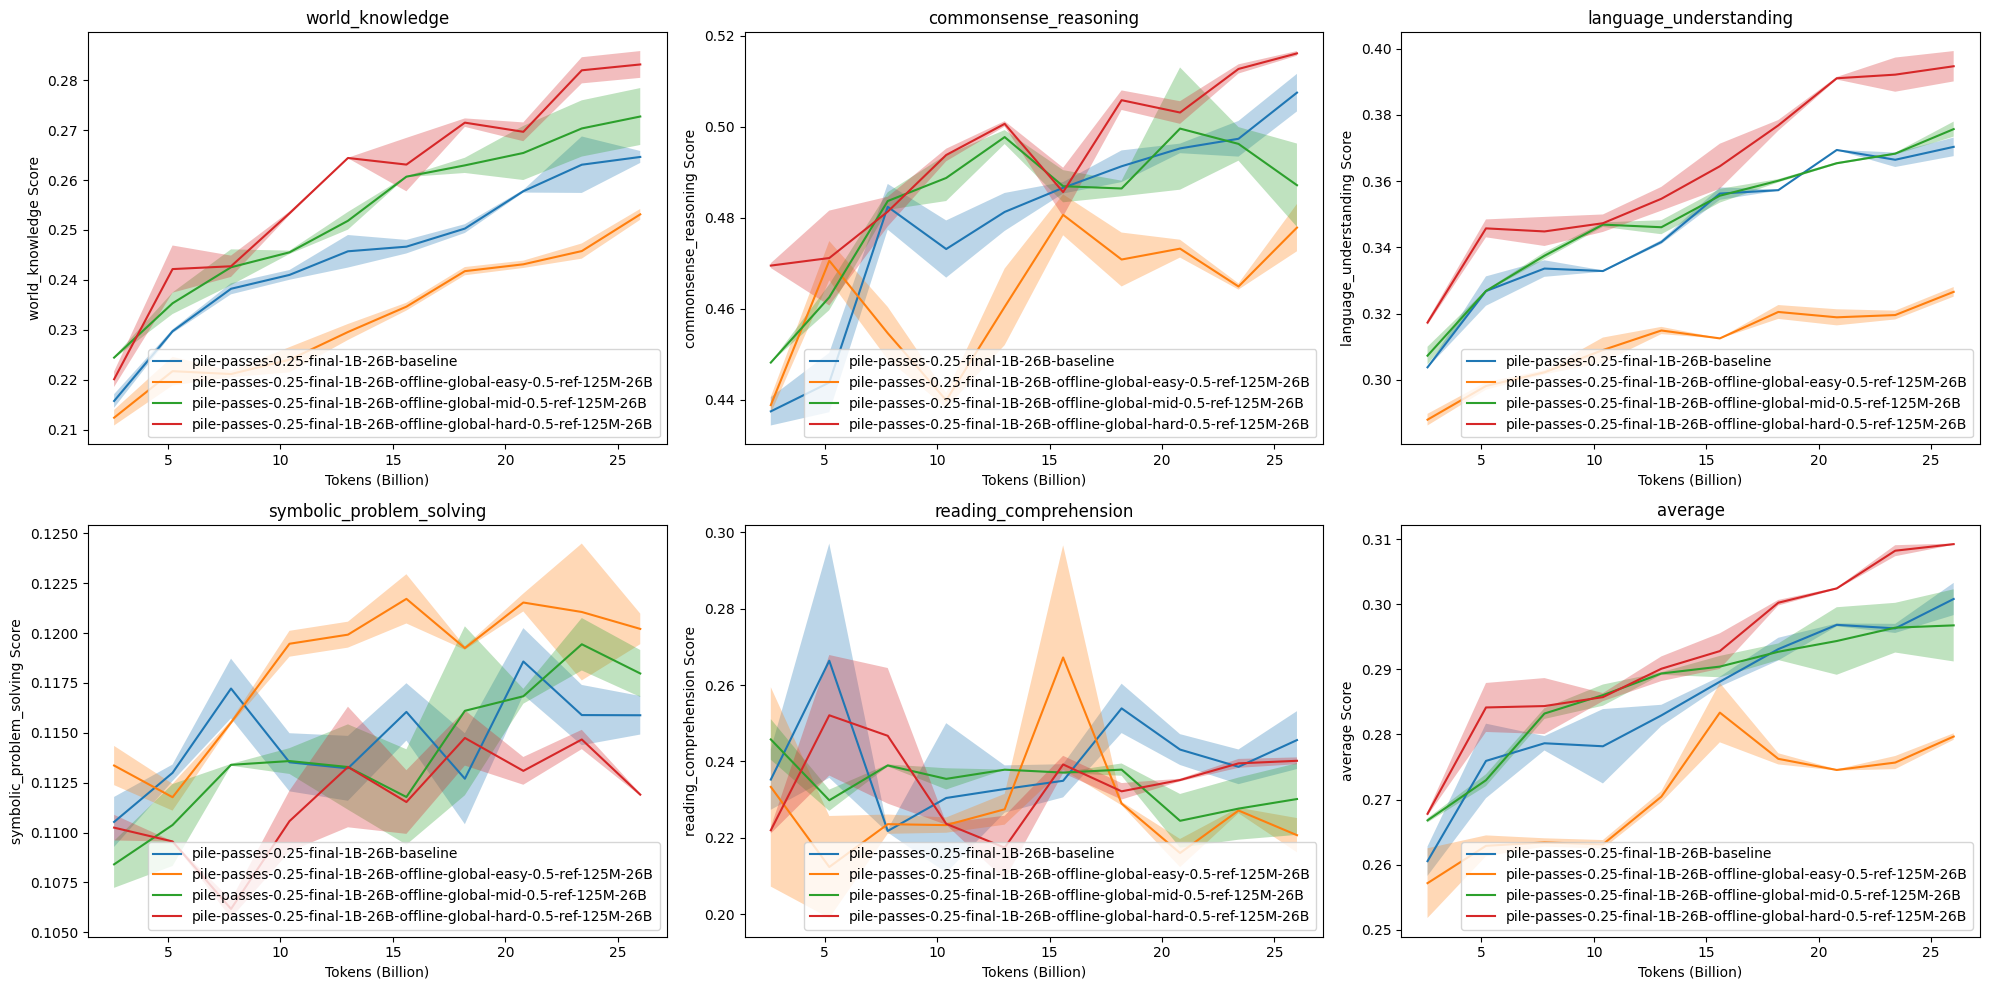

In [7]:
plot_all_results(pile_1b_processed_results)

In [132]:
print_tex_table(pile_1b_processed_results, 26.0)

pile-passes-0.25-final-1B-26B-baseline: 
&  $26.46 \scriptstyle{\pm0.12}$  &  $50.75 \scriptstyle{\pm0.41}$  &  $37.04 \scriptstyle{\pm0.28}$  &  $11.59 \scriptstyle{\pm0.10}$  &  $24.56 \scriptstyle{\pm0.76}$  &  $30.08 \scriptstyle{\pm0.25}$  
pile-passes-0.25-final-1B-26B-offline-global-easy-0.5-ref-125M-26B: 
&  $25.31 \scriptstyle{\pm0.11}$  &  $47.79 \scriptstyle{\pm0.52}$  &  $32.66 \scriptstyle{\pm0.15}$  &  $12.02 \scriptstyle{\pm0.08}$  &  $22.07 \scriptstyle{\pm0.45}$  &  $27.97 \scriptstyle{\pm0.05}$  
pile-passes-0.25-final-1B-26B-offline-global-mid-0.5-ref-125M-26B: 
&  $27.27 \scriptstyle{\pm0.57}$  &  $48.72 \scriptstyle{\pm0.92}$  &  $37.57 \scriptstyle{\pm0.23}$  &  $11.80 \scriptstyle{\pm0.12}$  &  $23.01 \scriptstyle{\pm0.94}$  &  $29.67 \scriptstyle{\pm0.55}$  
pile-passes-0.25-final-1B-26B-offline-global-hard-0.5-ref-125M-26B: 
&  $28.31 \scriptstyle{\pm0.27}$  &  $51.62 \scriptstyle{\pm0.05}$  &  $39.47 \scriptstyle{\pm0.46}$  &  $11.19 \scriptstyle{\pm0.01}$  & 

## MPT 1b results

In [22]:
mpt_1b_processed_results = pickle.load(open("data/train-curves/mpt_1b_processed_results.pkl", "rb"))

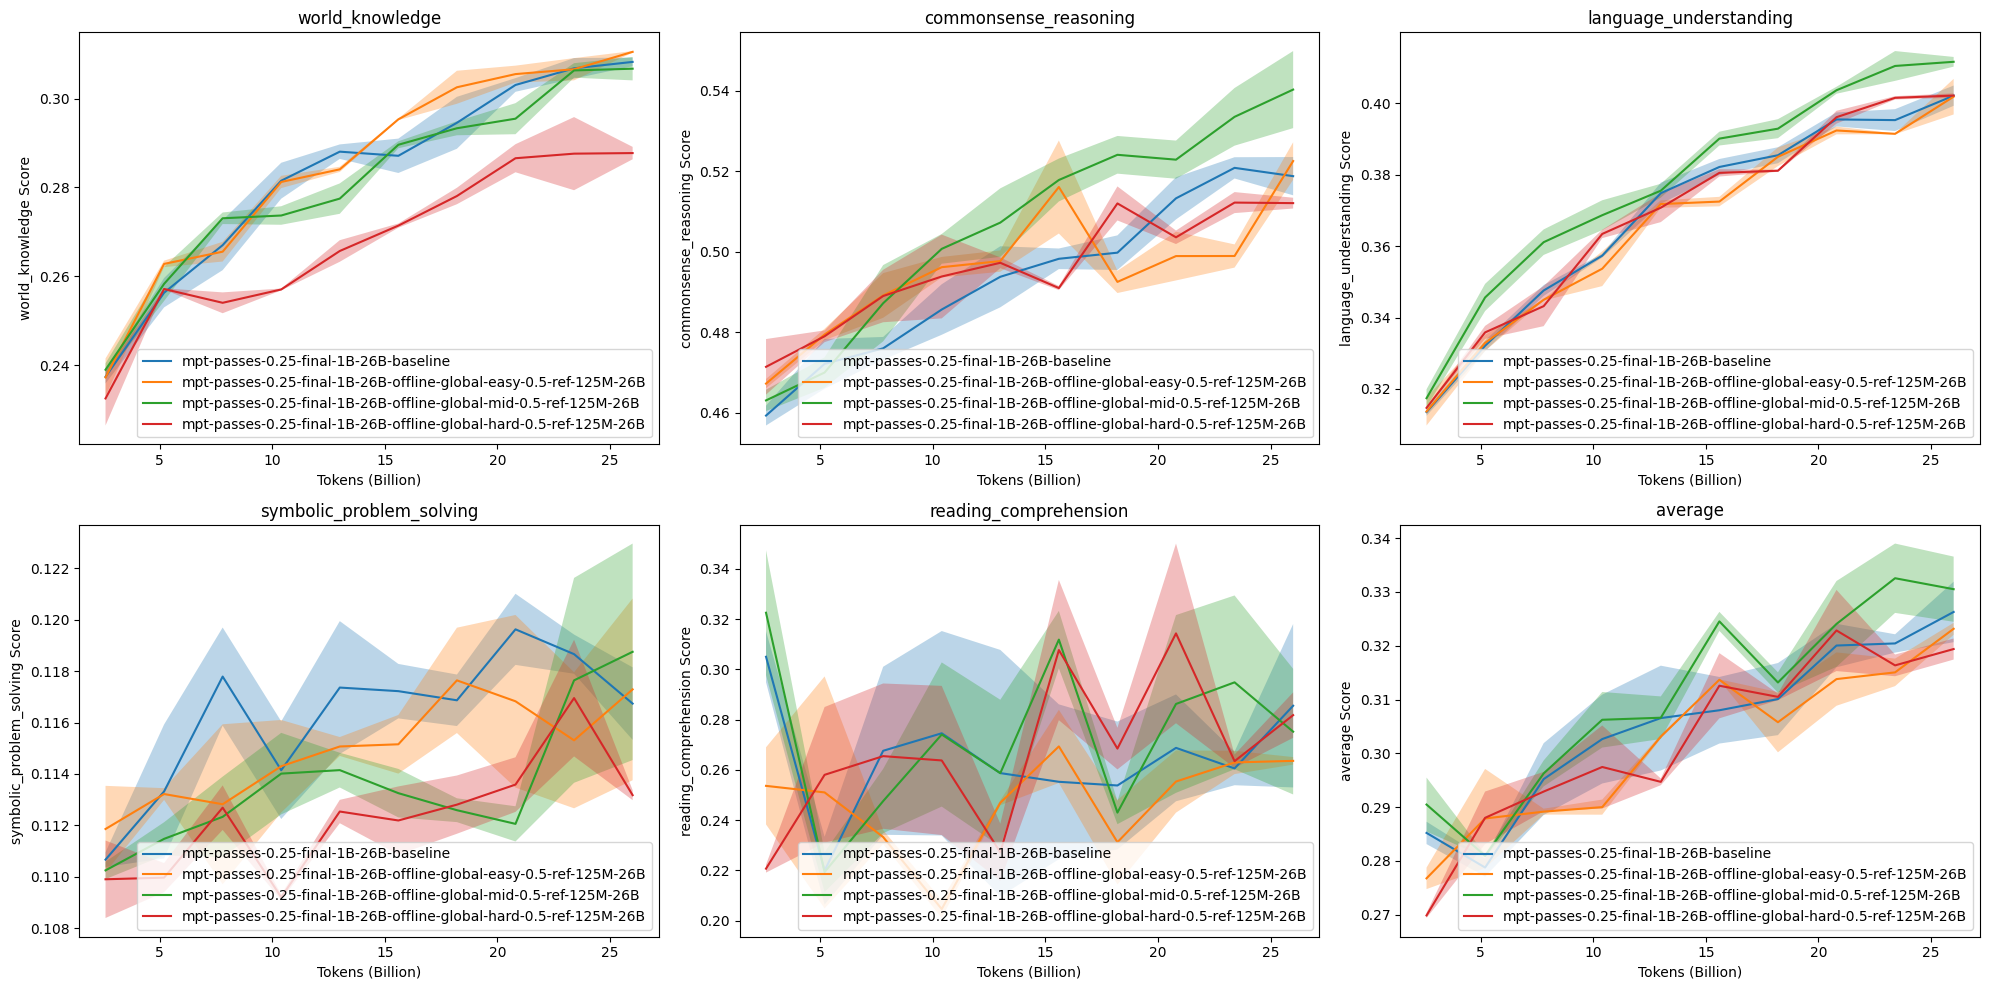

In [36]:
plot_all_results(mpt_1b_processed_results)

In [25]:
print_tex_table(mpt_1b_processed_results, 26.0)

mpt-passes-0.25-final-1B-26B-baseline: 
&  $30.82 \scriptstyle{\pm0.10}$  &  $51.88 \scriptstyle{\pm0.47}$  &  $40.21 \scriptstyle{\pm0.28}$  &  $11.67 \scriptstyle{\pm0.14}$  &  $28.55 \scriptstyle{\pm3.25}$  &  $32.63 \scriptstyle{\pm0.56}$  
mpt-passes-0.25-final-1B-26B-offline-global-easy-0.5-ref-125M-26B: 
&  $31.05 \scriptstyle{\pm0.02}$  &  $52.25 \scriptstyle{\pm0.47}$  &  $40.18 \scriptstyle{\pm0.50}$  &  $11.73 \scriptstyle{\pm0.35}$  &  $26.36 \scriptstyle{\pm0.15}$  &  $32.31 \scriptstyle{\pm0.11}$  
mpt-passes-0.25-final-1B-26B-offline-global-mid-0.5-ref-125M-26B: 
&  $30.67 \scriptstyle{\pm0.26}$  &  $54.03 \scriptstyle{\pm0.96}$  &  $41.16 \scriptstyle{\pm0.14}$  &  $11.88 \scriptstyle{\pm0.42}$  &  $27.52 \scriptstyle{\pm2.50}$  &  $33.05 \scriptstyle{\pm0.61}$  
mpt-passes-0.25-final-1B-26B-offline-global-hard-0.5-ref-125M-26B: 
&  $28.77 \scriptstyle{\pm0.14}$  &  $51.21 \scriptstyle{\pm0.13}$  &  $40.21 \scriptstyle{\pm0.06}$  &  $11.32 \scriptstyle{\pm0.02}$  &  $28

## Selection rate pile results

In [39]:
selection_rate_pile_1b_processed_results = pickle.load(open("data/train-curves/selection_rate_pile_1b_processed_results.pkl", "rb"))

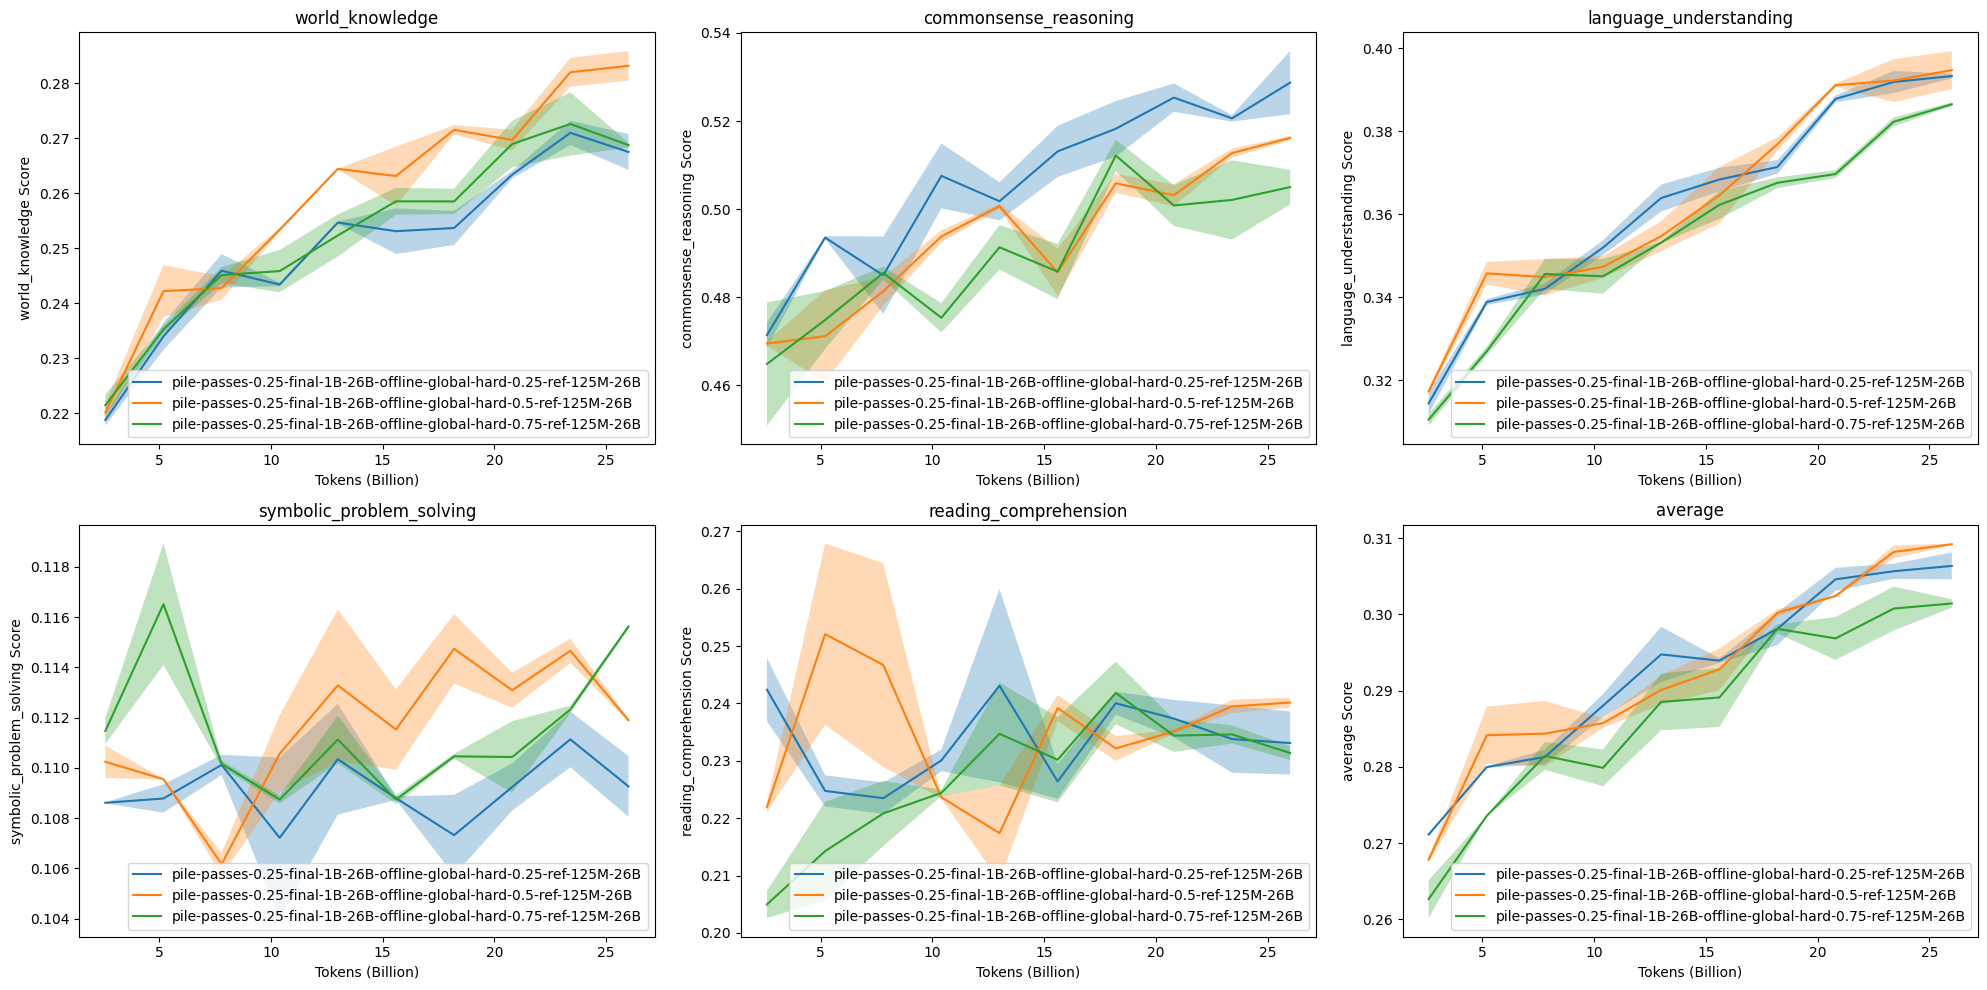

In [40]:
plot_all_results(selection_rate_pile_1b_processed_results)

In [41]:
print_tex_table(selection_rate_pile_1b_processed_results, 26.0)

pile-passes-0.25-final-1B-26B-offline-global-hard-0.25-ref-125M-26B: 
&  $26.75 \scriptstyle{\pm0.33}$  &  $52.87 \scriptstyle{\pm0.72}$  &  $39.33 \scriptstyle{\pm0.06}$  &  $10.93 \scriptstyle{\pm0.12}$  &  $23.31 \scriptstyle{\pm0.55}$  &  $30.64 \scriptstyle{\pm0.18}$  
pile-passes-0.25-final-1B-26B-offline-global-hard-0.5-ref-125M-26B: 
&  $28.31 \scriptstyle{\pm0.27}$  &  $51.62 \scriptstyle{\pm0.05}$  &  $39.47 \scriptstyle{\pm0.46}$  &  $11.19 \scriptstyle{\pm0.01}$  &  $24.02 \scriptstyle{\pm0.09}$  &  $30.92 \scriptstyle{\pm0.01}$  
pile-passes-0.25-final-1B-26B-offline-global-hard-0.75-ref-125M-26B: 
&  $26.87 \scriptstyle{\pm0.05}$  &  $50.50 \scriptstyle{\pm0.39}$  &  $38.65 \scriptstyle{\pm0.04}$  &  $11.56 \scriptstyle{\pm0.01}$  &  $23.14 \scriptstyle{\pm0.12}$  &  $30.14 \scriptstyle{\pm0.06}$  


## Selection rate mpt 1b results

In [44]:
selection_rate_mpt_1b_processed_results = pickle.load(open("data/train-curves/selection_rate_mpt_1b_processed_results.pkl", "rb"))

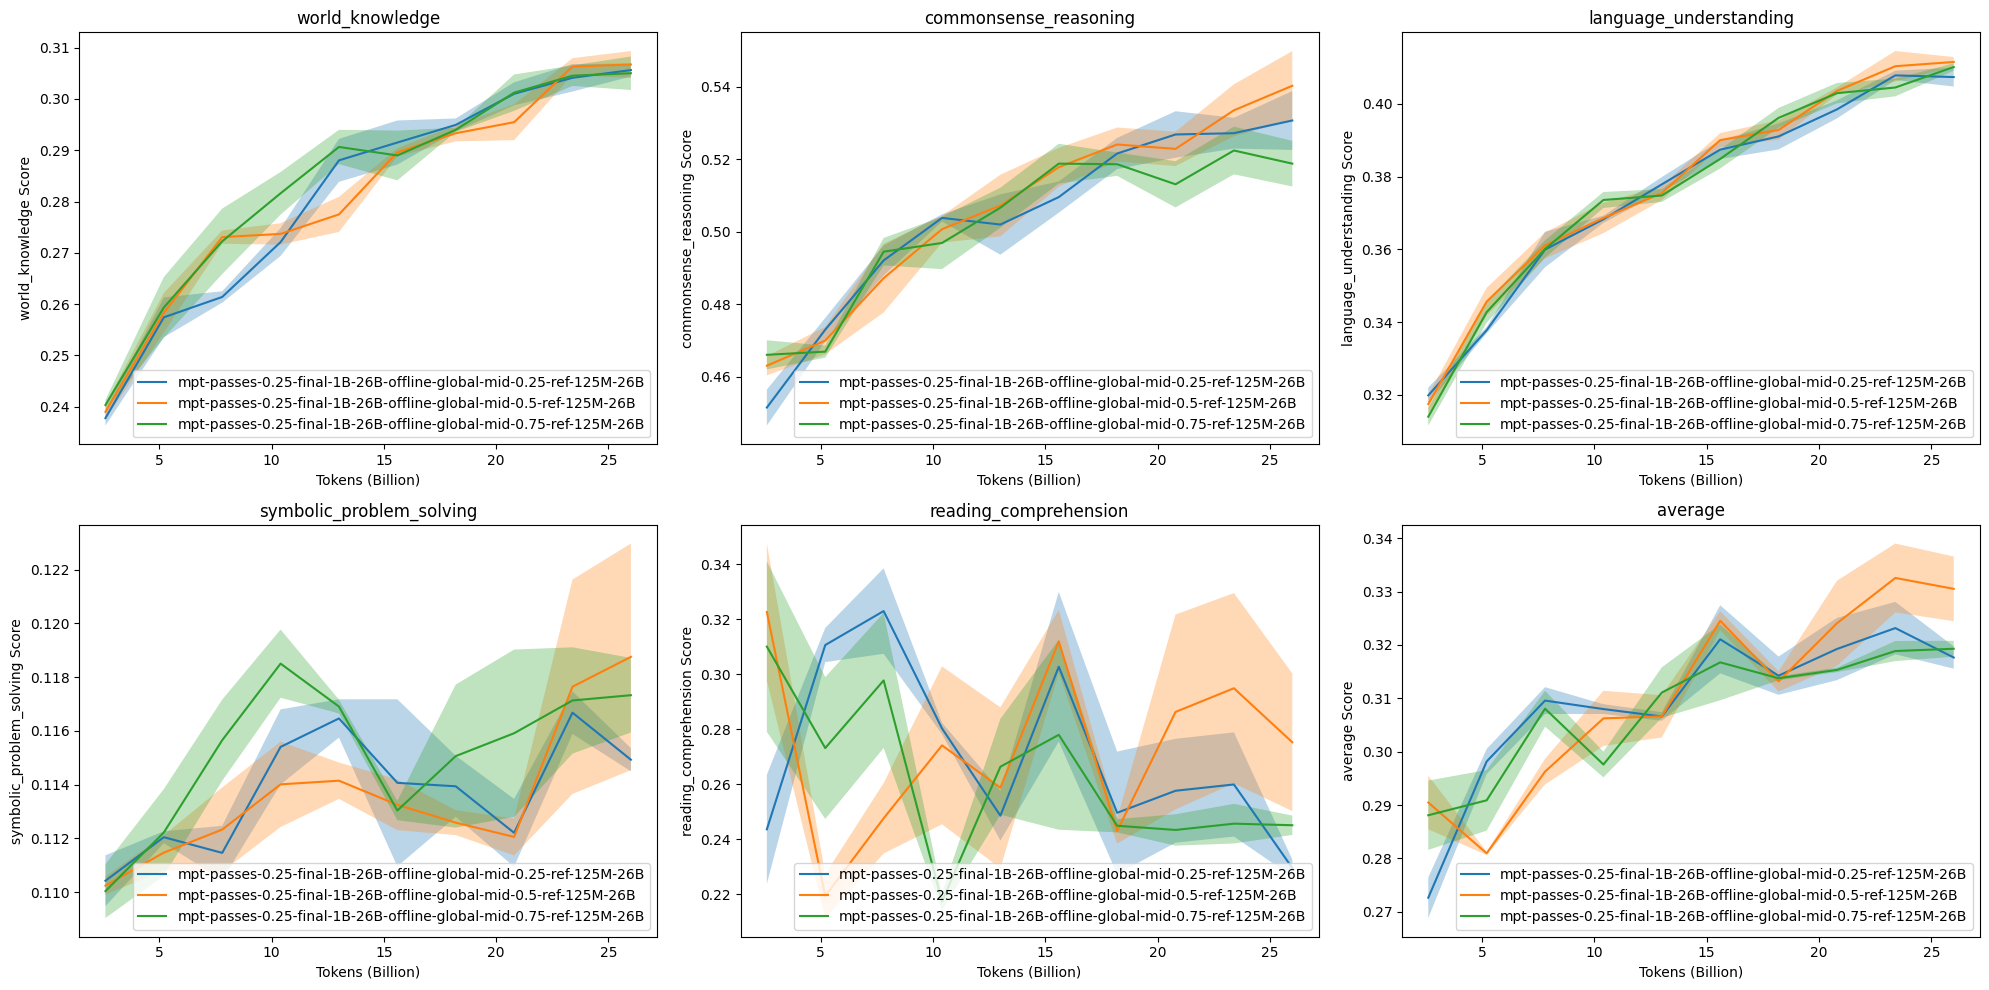

In [45]:
plot_all_results(selection_rate_mpt_1b_processed_results)

In [46]:
print_tex_table(selection_rate_mpt_1b_processed_results, 26.0)

mpt-passes-0.25-final-1B-26B-offline-global-mid-0.25-ref-125M-26B: 
&  $30.56 \scriptstyle{\pm0.13}$  &  $53.07 \scriptstyle{\pm0.81}$  &  $40.74 \scriptstyle{\pm0.26}$  &  $11.49 \scriptstyle{\pm0.04}$  &  $22.95 \scriptstyle{\pm0.31}$  &  $31.76 \scriptstyle{\pm0.21}$  
mpt-passes-0.25-final-1B-26B-offline-global-mid-0.5-ref-125M-26B: 
&  $30.67 \scriptstyle{\pm0.26}$  &  $54.03 \scriptstyle{\pm0.96}$  &  $41.16 \scriptstyle{\pm0.14}$  &  $11.88 \scriptstyle{\pm0.42}$  &  $27.52 \scriptstyle{\pm2.50}$  &  $33.05 \scriptstyle{\pm0.61}$  
mpt-passes-0.25-final-1B-26B-offline-global-mid-0.75-ref-125M-26B: 
&  $30.50 \scriptstyle{\pm0.33}$  &  $51.88 \scriptstyle{\pm0.63}$  &  $41.02 \scriptstyle{\pm0.10}$  &  $11.73 \scriptstyle{\pm0.14}$  &  $24.51 \scriptstyle{\pm0.35}$  &  $31.93 \scriptstyle{\pm0.15}$  


## Pile 3B results

In [10]:
pile_3b_processed_results = pickle.load(open("data/train-curves/pile_3b_processed_results.pkl", "rb"))

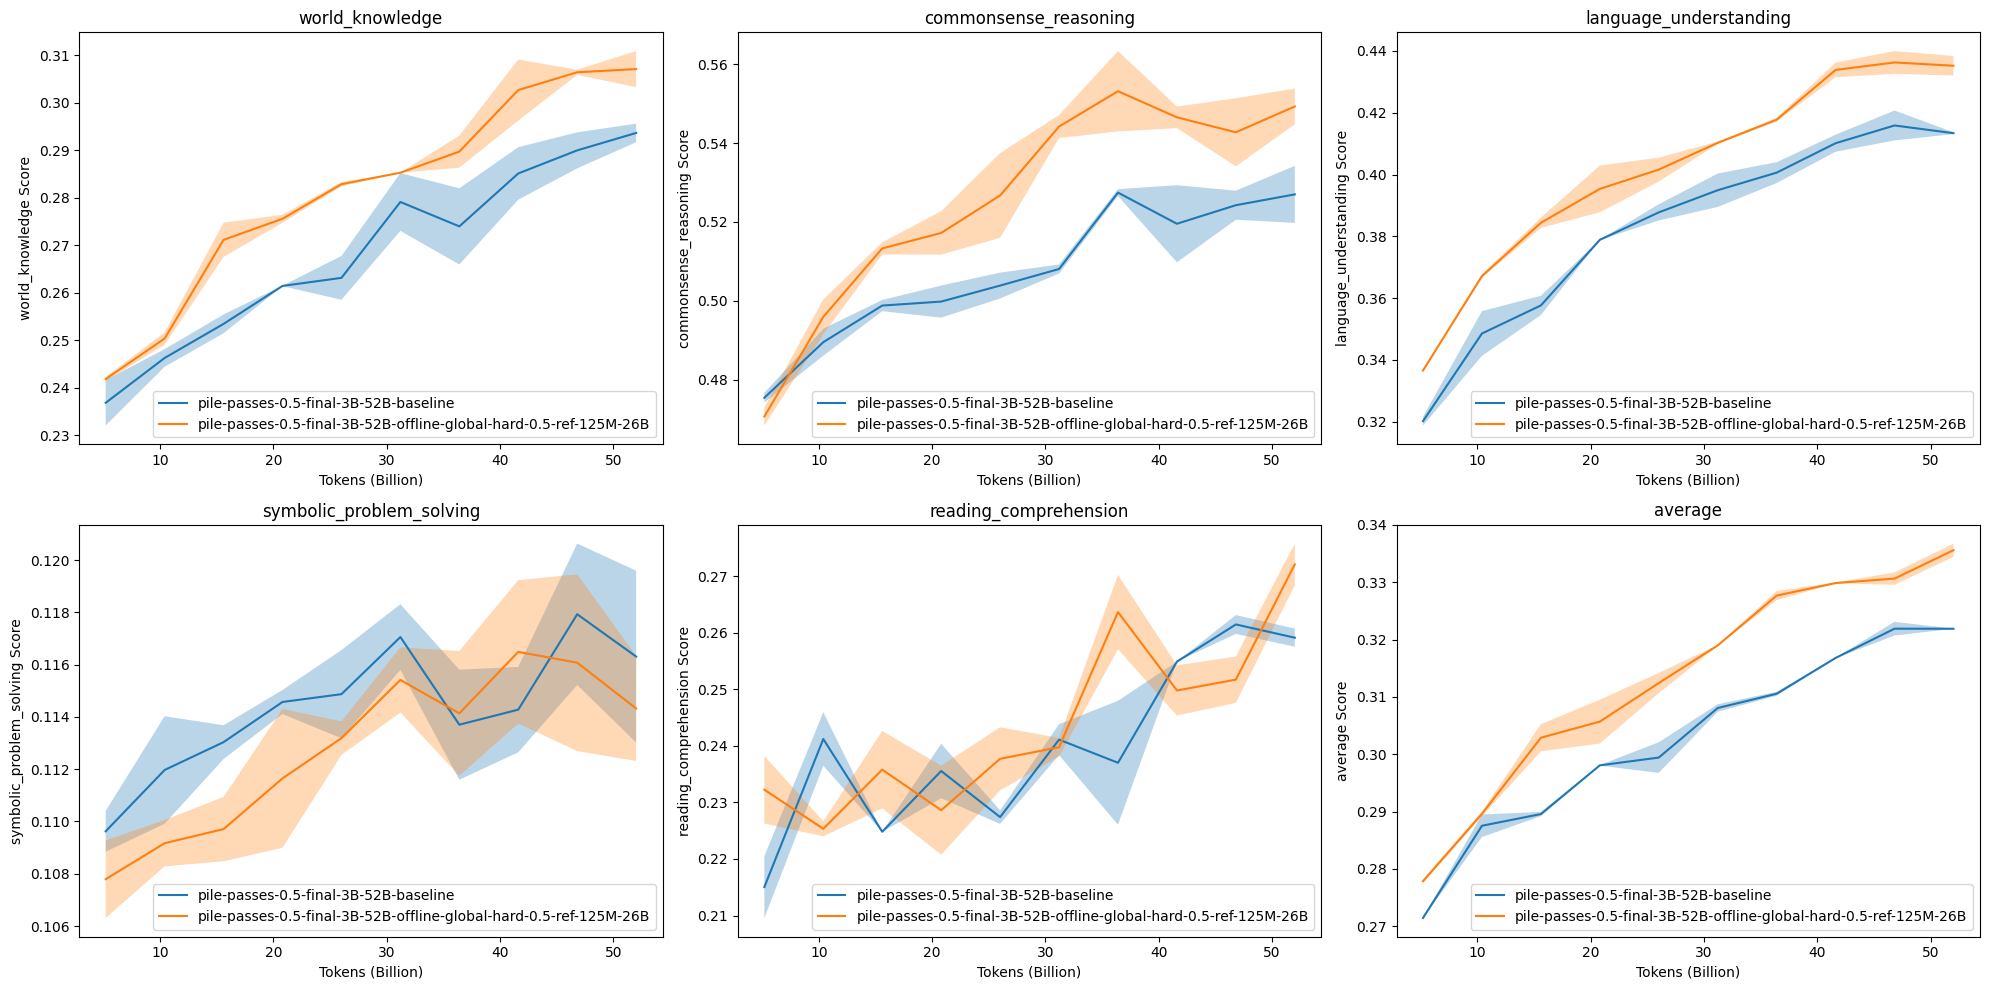

In [11]:
plot_all_results(pile_3b_processed_results)

In [20]:
print_tex_table(pile_3b_processed_results, 52.0)

pile-passes-0.5-final-3B-52B-baseline: 
&  $29.37 \scriptstyle{\pm0.20}$  &  $52.70 \scriptstyle{\pm0.72}$  &  $41.34 \scriptstyle{\pm0.03}$  &  $11.63 \scriptstyle{\pm0.33}$  &  $25.91 \scriptstyle{\pm0.16}$  &  $32.19 \scriptstyle{\pm0.00}$  
pile-passes-0.5-final-3B-52B-offline-global-hard-0.5-ref-125M-26B: 
&  $30.71 \scriptstyle{\pm0.38}$  &  $54.93 \scriptstyle{\pm0.45}$  &  $43.52 \scriptstyle{\pm0.32}$  &  $11.43 \scriptstyle{\pm0.20}$  &  $27.21 \scriptstyle{\pm0.37}$  &  $33.56 \scriptstyle{\pm0.12}$  


## MPT 3b results

In [11]:
mpt_3b_processed_results = pickle.load(open("data/train-curves/mpt_3b_processed_results.pkl", "rb"))

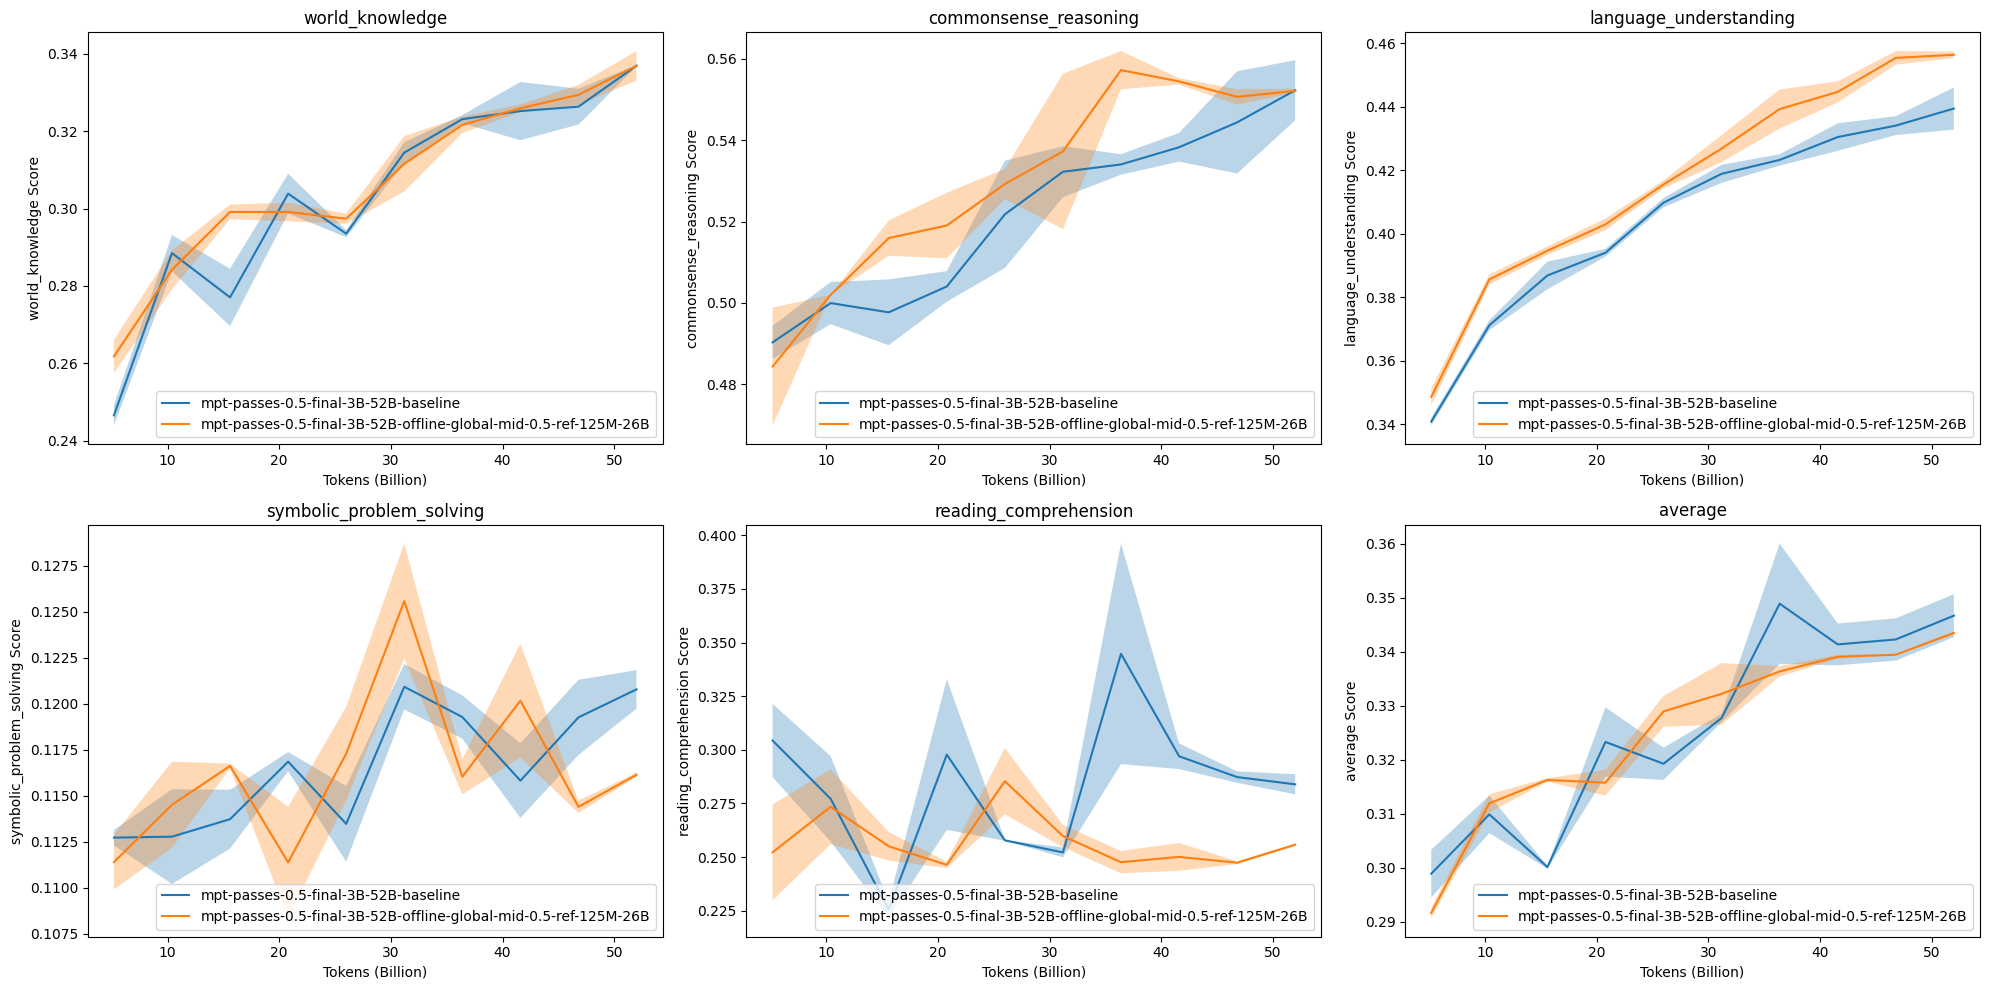

In [12]:
plot_all_results(mpt_3b_processed_results)

## Dolma Results

In [26]:
dolma_3b_processed_results = pickle.load(open("data/train-curves/dolma_3b_processed_results.pkl", "rb"))

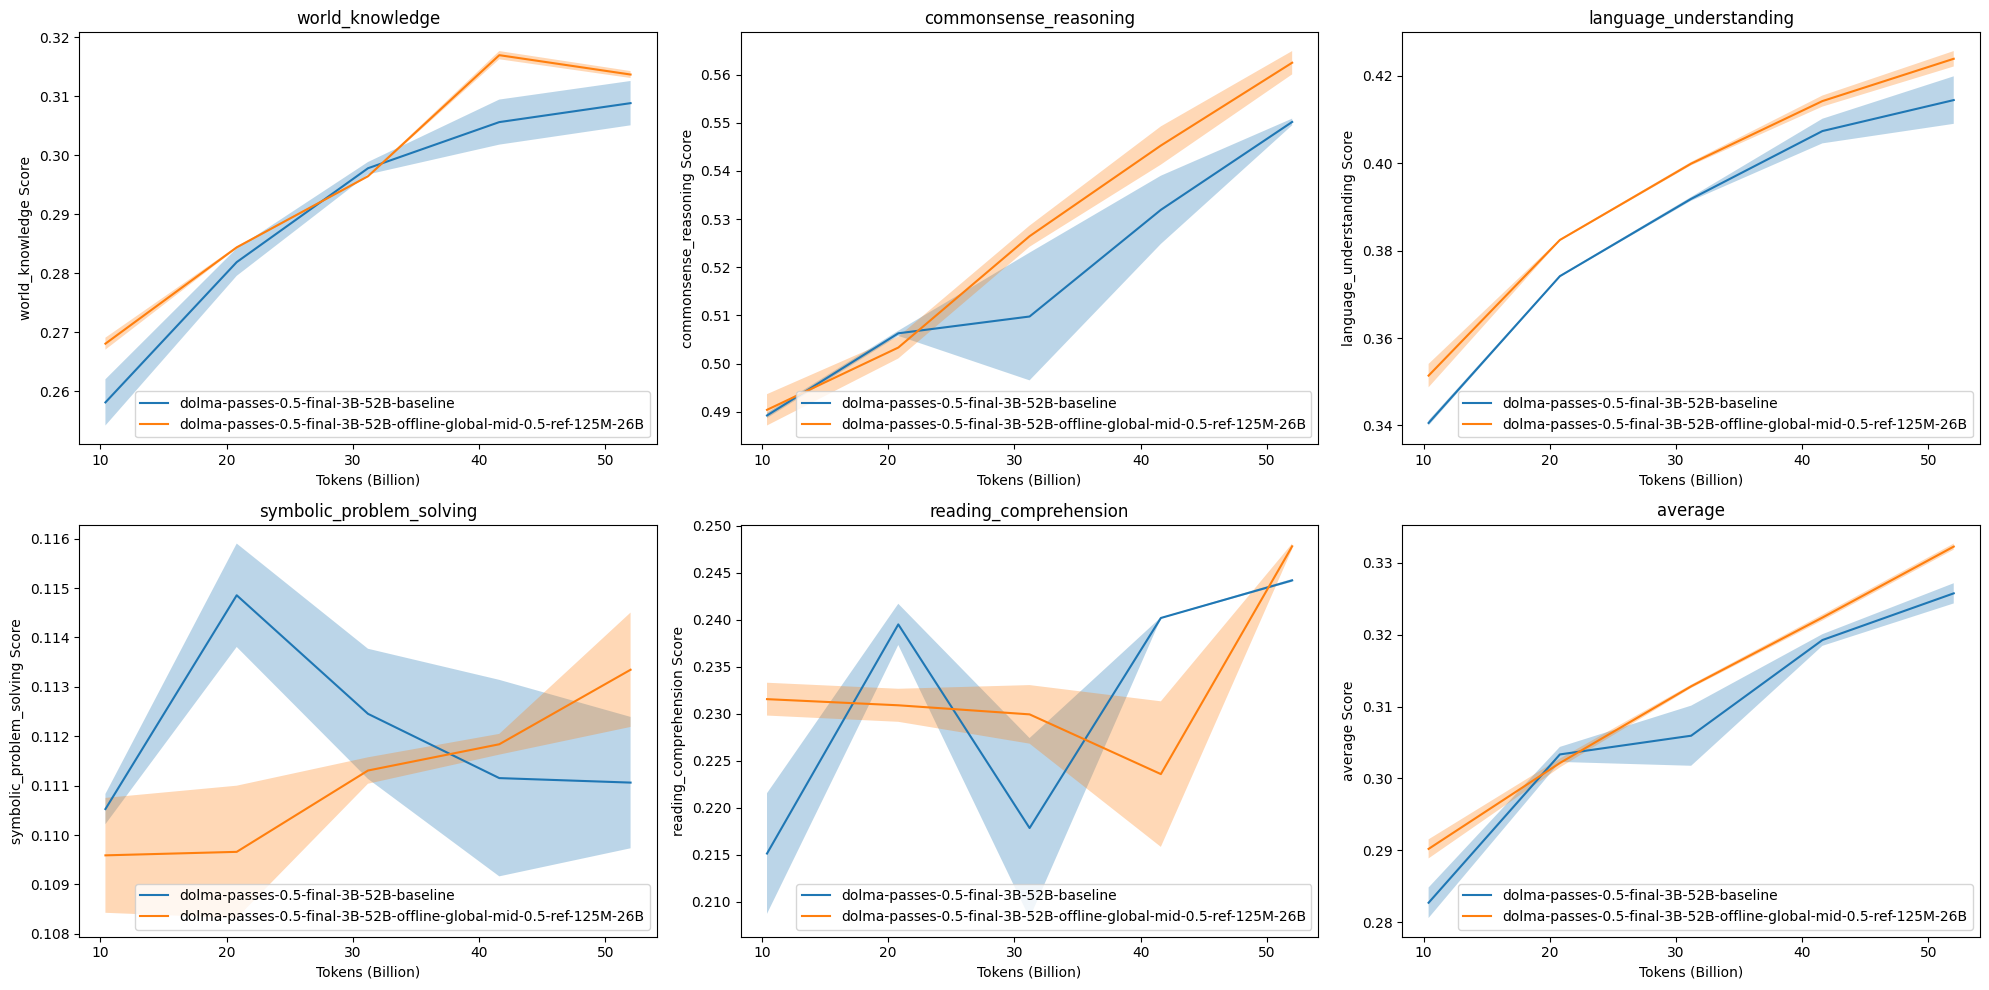

In [27]:
plot_all_results(dolma_3b_processed_results)